Using device: cpu

 STARTING EXPERIMENT FOR: FashionMNIST 

--- Step 1 & 3: Loading FashionMNIST and Defining Preprocessing ---

--- Step 2: Exploring and Visualizing Data (FashionMNIST) ---
Visualizing 4 random raw training examples from FashionMNIST:


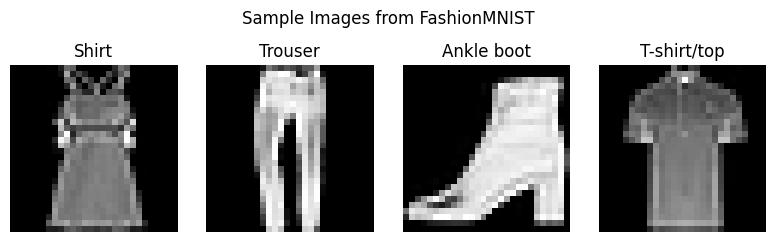

------------------------------

--- Step 4: Splitting FashionMNIST Training Data (90% Train / 10% Validation) ---
FashionMNIST sizes after split:
  Training Set:   54000
  Validation Set: 6000
  Test Set:       10000
------------------------------

--- Step 5: Creating DataLoaders for FashionMNIST ---
DataLoaders created.
------------------------------

--- Initializing Model, Loss, Optimizer for FashionMNIST ---
Model, Loss, Optimizer Initialized.
------------------------------

--- Step 6: Setting up TensorBoard for FashionMNIST ---
TensorBoard logs for FashionMNIST will be saved in: /Users/vinaygaddam/runs/FashionMNIST_LeNet5
------------------------------

--- Step 8 & 9: Training & Validating Model on FashionMNIST ---
Epoch [01/25], Train Loss: 0.5864, Train Acc: 78.33%, Val Loss: 0.4285, Val Acc: 84.93%, Time: 10.70s
Epoch [02/25], Train Loss: 0.3668, Train Acc: 86.53%, Val Loss: 0.3442, Val Acc: 87.55%, Time: 9.75s
Epoch [03/25], Train Loss: 0.3126, Train Acc: 88.37%, Val Loss: 

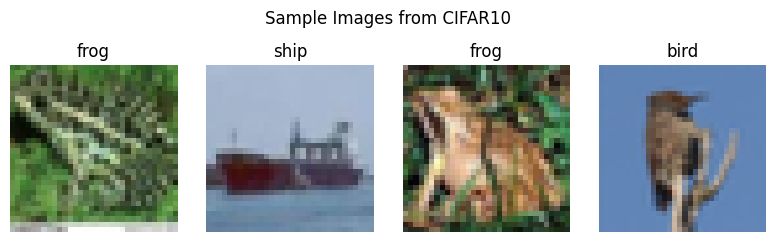

------------------------------

--- Step 4: Splitting CIFAR10 Training Data (90% Train / 10% Validation) ---
CIFAR10 sizes after split:
  Training Set:   45000
  Validation Set: 5000
  Test Set:       10000
------------------------------

--- Step 5: Creating DataLoaders for CIFAR10 ---
DataLoaders created.
------------------------------

--- Initializing Model, Loss, Optimizer for CIFAR10 ---
Model, Loss, Optimizer Initialized.
------------------------------

--- Step 6: Setting up TensorBoard for CIFAR10 ---
TensorBoard logs for CIFAR10 will be saved in: /Users/vinaygaddam/runs/CIFAR10_LeNet5
------------------------------

--- Step 8 & 9: Training & Validating Model on CIFAR10 ---
Epoch [01/25], Train Loss: 1.6164, Train Acc: 41.19%, Val Loss: 1.4120, Val Acc: 49.02%, Time: 38.36s
Epoch [02/25], Train Loss: 1.3034, Train Acc: 52.90%, Val Loss: 1.2661, Val Acc: 54.32%, Time: 36.91s
Epoch [03/25], Train Loss: 1.1680, Train Acc: 58.25%, Val Loss: 1.1775, Val Acc: 57.56%, Time: 37.14s
E

In [7]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.tensorboard import SummaryWriter
import os
import random

# --- Global Configuration ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 25 # Number of epochs to train for
BATCH_SIZE = 64
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.1 # 10% for validation
SEED = 42 # for reproducibility

# Set seed for reproducibility
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
if DEVICE == 'cuda':
    torch.cuda.manual_seed(SEED)
    # Potentially add for full reproducibility on CUDA, might impact performance
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

print(f"Using device: {DEVICE}")

# --- Step 7: Implement CNN Models (LeNet-5) ---
# Modified to accept input channels (1 for MNIST/FashionMNIST, 3 for CIFAR10)
class LeNet5(nn.Module):
    """
    LeNet-5 architecture implementation using PyTorch.
    Adapted for 28x28 or 32x32 inputs and variable input channels.
    """
    def __init__(self, num_classes=10, in_channels=1): # Added in_channels argument
        super(LeNet5, self).__init__()
        self.in_channels = in_channels
        # Convolutional layers
        self.layer1 = nn.Sequential(
            # Use in_channels argument here
            nn.Conv2d(in_channels=self.in_channels, out_channels=6, kernel_size=5, stride=1, padding=2), # Padding=2 maintains dimensions for 28x28 and works for 32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: (N, 6, 14, 14) for 28x28; (N, 6, 16, 16) for 32x32 -> Let's recalculate FC size
        )
        # Recalculation for FC layer size based on 32x32 input (CIFAR-10):
        # Input: (N, 3, 32, 32)
        # Layer 1 Conv (pad=2): (N, 6, 32, 32) -> ((32-5+2*2)/1 + 1 = 32)
        # Layer 1 Pool: (N, 6, 16, 16)
        # Layer 2 Conv (pad=0): (N, 16, 12, 12) -> ((16-5+2*0)/1 + 1 = 12)
        # Layer 2 Pool: (N, 16, 6, 6)
        # Flattened size for CIFAR-10 = 16 * 6 * 6 = 576
        # Flattened size for FashionMNIST (28x28, pad=2) = 16 * 5 * 5 = 400 (as calculated before)
        # --> We need to calculate the flattened size dynamically or pass it. Let's calculate dynamically.

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Dummy forward pass to determine the flattened size dynamically
        # This avoids hardcoding the size and makes the model more flexible
        with torch.no_grad():
            # Use a dummy input size appropriate for the datasets (e.g., 32x32 for CIFAR, 28x28 for MNIST)
            # Since CIFAR is larger, using its size works for calculation.
            # If using datasets with different sizes, might need separate models or more complex logic.
            dummy_input_size = 32 if self.in_channels == 3 else 28 # Assume 3 channels means 32x32
            dummy_input = torch.zeros(1, self.in_channels, dummy_input_size, dummy_input_size)
            dummy_output = self.layer2(self.layer1(dummy_input))
            self._flattened_size = int(torch.flatten(dummy_output, 1).shape[1])
            # print(f"Calculated flattened size: {self._flattened_size}") # Debug print

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=self._flattened_size, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=num_classes) # Output layer
        )

    def forward(self, x):
        """Forward pass through the network."""
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1) # Flatten the tensor for the FC layers
        x = self.fc_layers(x)
        return x

# --- Helper Function for Visualization (Step 2) ---
def visualize_samples(dataset_raw, class_names, dataset_name, num_samples=4):
    """Visualizes a few random samples from the raw dataset."""
    print(f"\n--- Step 2: Exploring and Visualizing Data ({dataset_name}) ---")

    # Function to show an image (expects a PIL Image)
    def imshow_pil(img, title=None):
        # Convert PIL image to numpy array. Handles both grayscale and RGB.
        img_array = np.asarray(img)
        if img_array.ndim == 2: # Grayscale
             plt.imshow(img_array, cmap='gray')
        else: # RGB
             plt.imshow(img_array)
        plt.axis('off') # Hide axes
        if title:
            plt.title(title)

    # Get a few random samples directly from the raw dataset
    random_indices = random.sample(range(len(dataset_raw)), num_samples)

    # Show images
    print(f"Visualizing {num_samples} random raw training examples from {dataset_name}:")
    fig = plt.figure(figsize=(8, 2.5)) # Adjusted figure size slightly
    for i, idx in enumerate(random_indices):
        image_raw, label_raw = dataset_raw[idx] # Access dataset directly
        ax = fig.add_subplot(1, num_samples, i+1, xticks=[], yticks=[])
        imshow_pil(image_raw, title=class_names[label_raw])
    plt.suptitle(f"Sample Images from {dataset_name}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()
    print("-" * 30)

# --- Main Experiment Function ---
def run_experiment(dataset_name, device, num_epochs, batch_size, learning_rate, validation_split, seed):
    """Loads a dataset, trains LeNet-5, evaluates, and logs results."""

    print("\n" + "="*50)
    print(f" STARTING EXPERIMENT FOR: {dataset_name} ")
    print("="*50)

    # --- Dataset Specific Configuration ---
    in_channels = 1 # Default for grayscale
    if dataset_name == 'FashionMNIST':
        dataset_class = datasets.FashionMNIST
        normalize_mean = (0.2860,)
        normalize_std = (0.3530,)
        class_names = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
        in_channels = 1
    elif dataset_name == 'CIFAR10':
        dataset_class = datasets.CIFAR10
        # Standard mean/std for CIFAR10
        normalize_mean = (0.4914, 0.4822, 0.4465)
        normalize_std = (0.2023, 0.1994, 0.2010)
        class_names = ('airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck')
        in_channels = 3 # CIFAR10 has 3 color channels
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

    # --- Step 1 & 3: Load Dataset and Define Preprocessing ---
    print(f"\n--- Step 1 & 3: Loading {dataset_name} and Defining Preprocessing ---")
    transform = transforms.Compose([
        transforms.ToTensor(), # Step 5: Convert Data to Torch Format
        transforms.Normalize(normalize_mean, normalize_std)
    ])
    try:
        full_train_dataset_raw = dataset_class(root='./data', train=True, download=True)
        full_train_dataset_transformed = dataset_class(root='./data', train=True, download=False, transform=transform)
        test_dataset = dataset_class(root='./data', train=False, download=True, transform=transform)
    except Exception as e:
        print(f"Error downloading or loading {dataset_name}: {e}")
        print("Please check your internet connection, SSL certificates, or disk space.")
        return # Stop experiment for this dataset if loading fails

    # --- Step 2: Explore and Visualize Data ---
    visualize_samples(full_train_dataset_raw, class_names, dataset_name)

    # --- Step 4: Split Training Data ---
    print(f"\n--- Step 4: Splitting {dataset_name} Training Data ({(1-validation_split)*100:.0f}% Train / {validation_split*100:.0f}% Validation) ---")
    num_train_total = len(full_train_dataset_transformed)
    num_val = int(validation_split * num_train_total)
    num_train = num_train_total - num_val
    generator = torch.Generator().manual_seed(seed)
    train_dataset, val_dataset = random_split(full_train_dataset_transformed, [num_train, num_val], generator=generator)
    print(f"{dataset_name} sizes after split:")
    print(f"  Training Set:   {len(train_dataset)}")
    print(f"  Validation Set: {len(val_dataset)}")
    print(f"  Test Set:       {len(test_dataset)}")
    print("-" * 30)

    # --- Step 5: Create DataLoaders ---
    print(f"\n--- Step 5: Creating DataLoaders for {dataset_name} ---")
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    print("DataLoaders created.")
    print("-" * 30)

    # --- Initialize Model, Loss, Optimizer ---
    print(f"\n--- Initializing Model, Loss, Optimizer for {dataset_name} ---")
    # Pass the correct number of input channels to the model
    model = LeNet5(num_classes=len(class_names), in_channels=in_channels).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print("Model, Loss, Optimizer Initialized.")
    # print(model) # Optional: print model summary
    print("-" * 30)

    # --- Step 6: Setup TensorBoard ---
    print(f"\n--- Step 6: Setting up TensorBoard for {dataset_name} ---")
    log_dir = os.path.join('runs', f"{dataset_name}_LeNet5")
    os.makedirs(log_dir, exist_ok=True)
    writer = SummaryWriter(log_dir=log_dir)
    print(f"TensorBoard logs for {dataset_name} will be saved in: {os.path.abspath(log_dir)}")
    print("-" * 30)

    # --- Step 8 & 9: Train Model & Evaluate Train/Validation Accuracy ---
    print(f"\n--- Step 8 & 9: Training & Validating Model on {dataset_name} ---")
    start_time = time.time()
    best_val_acc = 0.0
    final_train_acc_at_best_val = 0.0
    final_val_acc_at_best_val = 0.0
    final_train_loss_at_best_val = float('inf')
    final_val_loss_at_best_val = float('inf')


    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        epoch_train_loss = running_loss / len(train_dataset)
        epoch_train_acc = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        epoch_val_loss = val_loss / len(val_dataset)
        epoch_val_acc = 100 * correct_val / total_val

        epoch_end_time = time.time()
        print(f"Epoch [{epoch+1:02d}/{num_epochs}], "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%, "
              f"Time: {epoch_end_time - epoch_start_time:.2f}s")

        # Log to TensorBoard
        writer.add_scalar('Loss/Train', epoch_train_loss, epoch + 1)
        writer.add_scalar('Accuracy/Train', epoch_train_acc, epoch + 1)
        writer.add_scalar('Loss/Validation', epoch_val_loss, epoch + 1)
        writer.add_scalar('Accuracy/Validation', epoch_val_acc, epoch + 1)
        writer.flush()

        # Store results from the epoch with the best validation accuracy
        if epoch_val_acc > best_val_acc:
             best_val_acc = epoch_val_acc
             final_train_acc_at_best_val = epoch_train_acc
             final_val_acc_at_best_val = epoch_val_acc
             final_train_loss_at_best_val = epoch_train_loss
             final_val_loss_at_best_val = epoch_val_loss

    training_time = time.time() - start_time
    print(f"--- {dataset_name} Training Finished --- Total Time: {training_time:.2f}s ({training_time/60:.2f} minutes)")
    print("-" * 30)

    # --- Step 10: Evaluate on Test Set ---
    print(f"\n--- Step 10: Evaluating on {dataset_name} Test Set ---")
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    final_test_loss = test_loss / len(test_dataset)
    final_test_acc = 100 * correct_test / total_test
    print(f"{dataset_name} Test Loss: {final_test_loss:.4f}")
    print(f"{dataset_name} Test Accuracy: {final_test_acc:.2f}%")
    print("-" * 30)

    # --- Final Summary for Grading ---
    print("\n" + "="*30)
    print(f"   RESULTS SUMMARY FOR: {dataset_name}")
    print("="*30)
    print(f"CNN Architecture:   LeNet-5")
    print(f"Epochs Trained:     {num_epochs}")
    print(f"Batch Size:         {batch_size}")
    print(f"Learning Rate:      {learning_rate}")
    print(f"Optimizer:          Adam")
    print(f"Validation Split:   {validation_split*100:.0f}%")
    print("-" * 30)
    print("Metrics at Epoch with Best Validation Accuracy:")
    # Handle case where training might not improve (best_val_acc remains 0)
    if best_val_acc > 0:
        print(f"  Training Accuracy:   {final_train_acc_at_best_val:.2f}%")
        print(f"  Validation Accuracy: {final_val_acc_at_best_val:.2f}%")
        print(f"  Training Loss:       {final_train_loss_at_best_val:.4f}")
        print(f"  Validation Loss:     {final_val_loss_at_best_val:.4f}")
    else:
        print("  No improvement in validation accuracy observed.")
    print("-" * 30)
    print(f"Final Test Accuracy:   {final_test_acc:.2f}%")
    print(f"Final Test Loss:       {final_test_loss:.4f}")
    print("="*30)

    # Close the TensorBoard writer
    writer.close()
    print(f"\nTensorBoard writer for {dataset_name} closed.")
    print("="*50)
    print(f" COMPLETED EXPERIMENT FOR: {dataset_name} ")
    print("="*50 + "\n")


# --- Main Execution Block ---
if __name__ == "__main__":
    # List of datasets to run experiments on
    datasets_to_run = ['FashionMNIST', 'CIFAR10']

    for dataset in datasets_to_run:
        run_experiment(
            dataset_name=dataset,
            device=DEVICE,
            num_epochs=NUM_EPOCHS,
            batch_size=BATCH_SIZE,
            learning_rate=LEARNING_RATE,
            validation_split=VALIDATION_SPLIT,
            seed=SEED
        )

    print("\nAll experiments completed.")
    print("Check the 'runs' directory for TensorBoard logs:")
    for dataset in datasets_to_run:
         print(f" - runs/{dataset}_LeNet5")
    print("\nTo view TensorBoard, run the following command in your terminal:")
    print(f"tensorboard --logdir \"{os.path.abspath('runs')}\"")



# LeNet-5 Implementation on FashionMNIST and CIFAR-10

##This notebook implements the LeNet-5 architecture and trains/evaluates it on two datasets: FashionMNIST and CIFAR-10. It follows the steps outlined in the project requirements, including data loading, visualization, splitting, model implementation, training, evaluation, and result analysis with TensorBoard logging and plots.


## 1. Import Required Libraries


In [8]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.tensorboard import SummaryWriter # For TensorBoard logging
import os
import random
from tqdm.notebook import tqdm # For progress bars in notebooks
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import pandas as pd


## 2. Configuration and Setup


In [10]:
# --- Global Configuration ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 25 # Number of epochs to train for (as per project suggestion: 25-50)
BATCH_SIZE = 64
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.1 # Use 10% of training data for validation
SEED = 42 # for reproducibility

# --- Set seed for reproducibility ---
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
if DEVICE == 'cuda':
    torch.cuda.manual_seed(SEED)
    # For full reproducibility on CUDA, you might consider these, but they can impact performance
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

print(f"Using device: {DEVICE}")

# --- Setup TensorBoard Logging Directory ---
LOG_DIR_BASE = 'runs' # Base directory for TensorBoard logs
os.makedirs(LOG_DIR_BASE, exist_ok=True)
print(f"TensorBoard base log directory: {os.path.abspath(LOG_DIR_BASE)}")


Using device: cpu
TensorBoard base log directory: /Users/vinaygaddam/runs


## 3. Model Definition (LeNet-5)

Implementing the LeNet-5 architecture, adapted slightly for variable input channels (1 for FashionMNIST, 3 for CIFAR-10) and input sizes (28x28 or 32x32).


In [11]:
# --- Step 7: Implement CNN Models (LeNet-5) ---
class LeNet5(nn.Module):
    """
    LeNet-5 architecture implementation using PyTorch.
    Adapted for 28x28 or 32x32 inputs and variable input channels.
    """
    def __init__(self, num_classes=10, in_channels=1):
        super(LeNet5, self).__init__()
        self.in_channels = in_channels
        # Convolutional Layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=6, kernel_size=5, stride=1, padding=2), # Padding=2 helps maintain dimensions
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Convolutional Layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Dummy forward pass to determine the flattened size dynamically
        with torch.no_grad():
            dummy_input_size = 32 if self.in_channels == 3 else 28
            dummy_input = torch.zeros(1, self.in_channels, dummy_input_size, dummy_input_size)
            dummy_output = self.layer2(self.layer1(dummy_input))
            self._flattened_size = int(torch.flatten(dummy_output, 1).shape[1])
            # print(f"Calculated flattened size for {dummy_input_size}x{dummy_input_size} with {self.in_channels} channels: {self._flattened_size}")


        # Fully Connected Layers
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=self._flattened_size, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=num_classes) # Output layer
        )

    def forward(self, x):
        """Forward pass through the network."""
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.fc_layers(x)
        return x


## 4. Helper Functions

Functions for data visualization, training loop, and evaluation.


In [12]:
# --- Helper Function for Data Visualization ---
def visualize_samples(dataset_raw, class_names, dataset_name, num_samples=4):
    """Visualizes a few random samples from the raw dataset."""
    print(f"\n--- Visualizing Data ({dataset_name}) ---") # Step 2 indicator

    def imshow_pil(img, title=None):
        img_array = np.asarray(img)
        if img_array.ndim == 2: # Grayscale
             plt.imshow(img_array, cmap='gray')
        else: # RGB
             plt.imshow(img_array)
        plt.axis('off')
        if title:
            plt.title(title)

    random_indices = random.sample(range(len(dataset_raw)), num_samples)

    print(f"Visualizing {num_samples} random raw training examples from {dataset_name}:")
    fig = plt.figure(figsize=(8, 2.5))
    for i, idx in enumerate(random_indices):
        image_raw, label_raw = dataset_raw[idx]
        ax = fig.add_subplot(1, num_samples, i+1, xticks=[], yticks=[])
        imshow_pil(image_raw, title=class_names[label_raw])
    plt.suptitle(f"Sample Images from {dataset_name}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Helper Function for Training ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, writer, dataset_name):
    """Trains the model and logs metrics.""" # Addresses Step 8 & 9
    print(f"\n--- Training & Validating Model on {dataset_name} ---")
    start_time = time.time()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = 0.0
    metrics_at_best_val = {} # To store metrics of the best epoch

    for epoch in tqdm(range(num_epochs), desc=f"Training {dataset_name}"):
        epoch_start_time = time.time()
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        epoch_train_loss = running_loss / len(train_loader.dataset) # Use dataset length for average
        epoch_train_acc = 100 * correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        epoch_val_loss = val_loss / len(val_loader.dataset) # Use dataset length for average
        epoch_val_acc = 100 * correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        epoch_end_time = time.time()
        print(f"Epoch [{epoch+1:02d}/{num_epochs}], "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%, " # Validation loss printed (Step 8)
              f"Time: {epoch_end_time - epoch_start_time:.2f}s")

        # Log to TensorBoard (Step 6)
        if writer:
            writer.add_scalar(f'{dataset_name}/Loss/Train', epoch_train_loss, epoch + 1)
            writer.add_scalar(f'{dataset_name}/Accuracy/Train', epoch_train_acc, epoch + 1)
            writer.add_scalar(f'{dataset_name}/Loss/Validation', epoch_val_loss, epoch + 1)
            writer.add_scalar(f'{dataset_name}/Accuracy/Validation', epoch_val_acc, epoch + 1)
            writer.flush()

        # Store metrics from the epoch with the best validation accuracy
        if epoch_val_acc > best_val_acc:
             best_val_acc = epoch_val_acc
             metrics_at_best_val = {
                 'train_acc': epoch_train_acc,
                 'val_acc': epoch_val_acc,
                 'train_loss': epoch_train_loss,
                 'val_loss': epoch_val_loss,
                 'epoch': epoch + 1
             }

    training_time = time.time() - start_time
    print(f"--- {dataset_name} Training Finished --- Total Time: {training_time:.2f}s ({training_time/60:.2f} minutes)")

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies
    }
    return history, metrics_at_best_val

# --- Helper Function for Evaluation ---
def evaluate_model(model, test_loader, criterion, device, dataset_name):
    """Evaluates the model on the test set and returns metrics.""" # Addresses Step 10
    print(f"\n--- Evaluating on {dataset_name} Test Set ---")
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Evaluating {dataset_name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    final_test_loss = test_loss / len(test_loader.dataset) # Use dataset length for average
    final_test_acc = 100 * correct_test / total_test

    print(f"{dataset_name} Test Loss: {final_test_loss:.4f}")
    print(f"{dataset_name} Test Accuracy: {final_test_acc:.2f}%") # Test accuracy reported (Step 10)

    results = {
        'test_loss': final_test_loss,
        'test_acc': final_test_acc,
        'labels': np.array(all_labels),
        'predictions': np.array(all_predictions)
    }
    return results


## 5. Experiment: FashionMNIST

Running the full pipeline for the FashionMNIST dataset.



 STARTING EXPERIMENT FOR: FashionMNIST 

--- Loading FashionMNIST and Defining Preprocessing ---

--- Visualizing Data (FashionMNIST) ---
Visualizing 4 random raw training examples from FashionMNIST:


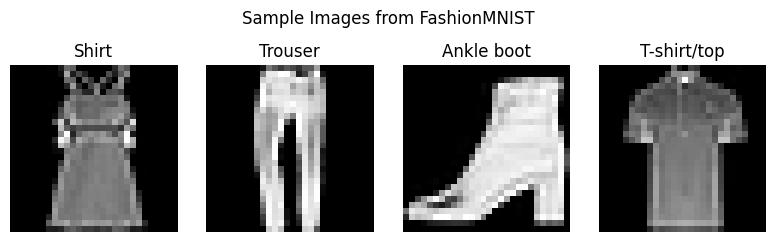


--- Splitting FashionMNIST Training Data ---
FashionMNIST sizes after split:
  Training Set:   54000
  Validation Set: 6000
  Test Set:       10000

--- Creating DataLoaders for FashionMNIST ---
DataLoaders created.

--- Initializing Model, Loss, Optimizer for FashionMNIST ---
Model, Loss, Optimizer Initialized.

--- Setting up TensorBoard for FashionMNIST ---
TensorBoard logs for FashionMNIST saved in: /Users/vinaygaddam/runs/FashionMNIST_LeNet5

--- Training & Validating Model on FashionMNIST ---


Training FashionMNIST:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [01/25], Train Loss: 0.5864, Train Acc: 78.33%, Val Loss: 0.4285, Val Acc: 84.93%, Time: 10.75s
Epoch [02/25], Train Loss: 0.3668, Train Acc: 86.53%, Val Loss: 0.3442, Val Acc: 87.55%, Time: 10.60s
Epoch [03/25], Train Loss: 0.3126, Train Acc: 88.37%, Val Loss: 0.3153, Val Acc: 88.37%, Time: 10.86s
Epoch [04/25], Train Loss: 0.2816, Train Acc: 89.54%, Val Loss: 0.2984, Val Acc: 89.37%, Time: 11.08s
Epoch [05/25], Train Loss: 0.2576, Train Acc: 90.44%, Val Loss: 0.2904, Val Acc: 89.20%, Time: 12.11s
Epoch [06/25], Train Loss: 0.2420, Train Acc: 90.98%, Val Loss: 0.2891, Val Acc: 90.03%, Time: 13.36s
Epoch [07/25], Train Loss: 0.2254, Train Acc: 91.64%, Val Loss: 0.2711, Val Acc: 90.40%, Time: 12.36s
Epoch [08/25], Train Loss: 0.2114, Train Acc: 92.18%, Val Loss: 0.2679, Val Acc: 90.13%, Time: 12.60s
Epoch [09/25], Train Loss: 0.1999, Train Acc: 92.47%, Val Loss: 0.2802, Val Acc: 90.40%, Time: 10.77s
Epoch [10/25], Train Loss: 0.1883, Train Acc: 93.00%, Val Loss: 0.2712, Val Acc: 9

Evaluating FashionMNIST:   0%|          | 0/157 [00:00<?, ?it/s]

FashionMNIST Test Loss: 0.4528
FashionMNIST Test Accuracy: 89.70%

TensorBoard writer for FashionMNIST closed.
 COMPLETED EXPERIMENT FOR: FashionMNIST 



In [13]:
# --- FashionMNIST Setup ---
DATASET_NAME_FM = 'FashionMNIST'
print("\n" + "="*50)
print(f" STARTING EXPERIMENT FOR: {DATASET_NAME_FM} ")
print("="*50)

# Dataset specific config
dataset_class_fm = datasets.FashionMNIST
normalize_mean_fm = (0.2860,) # FashionMNIST is grayscale
normalize_std_fm = (0.3530,)
class_names_fm = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                  'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
in_channels_fm = 1 # Grayscale

# --- Step 1 & 3: Load Dataset and Define Preprocessing ---
print(f"\n--- Loading {DATASET_NAME_FM} and Defining Preprocessing ---")
transform_fm = transforms.Compose([
    transforms.ToTensor(), # Step 5: Convert Data to Torch Format
    transforms.Normalize(normalize_mean_fm, normalize_std_fm)
])
try:
    # Load raw dataset (PIL Images) ONLY for visualization
    full_train_dataset_raw_fm = dataset_class_fm(root='./data', train=True, download=True)
    # Load dataset WITH transforms for training/validation/testing
    full_train_dataset_transformed_fm = dataset_class_fm(root='./data', train=True, download=False, transform=transform_fm)
    test_dataset_fm = dataset_class_fm(root='./data', train=False, download=True, transform=transform_fm)
except Exception as e:
    print(f"Error downloading or loading {DATASET_NAME_FM}: {e}")
    # Optionally, add more robust error handling or exit

# --- Step 2: Explore and Visualize Data ---
if 'full_train_dataset_raw_fm' in locals(): # Check if dataset loaded successfully
    visualize_samples(full_train_dataset_raw_fm, class_names_fm, DATASET_NAME_FM)

# --- Step 4: Split Training Data ---
print(f"\n--- Splitting {DATASET_NAME_FM} Training Data ---")
num_train_total_fm = len(full_train_dataset_transformed_fm)
num_val_fm = int(VALIDATION_SPLIT * num_train_total_fm)
num_train_fm = num_train_total_fm - num_val_fm
generator_fm = torch.Generator().manual_seed(SEED) # For reproducible split
train_dataset_fm, val_dataset_fm = random_split(full_train_dataset_transformed_fm, [num_train_fm, num_val_fm], generator=generator_fm)
print(f"{DATASET_NAME_FM} sizes after split:")
print(f"  Training Set:   {len(train_dataset_fm)}")
print(f"  Validation Set: {len(val_dataset_fm)}")
print(f"  Test Set:       {len(test_dataset_fm)}")

# --- Step 5: Create DataLoaders ---
print(f"\n--- Creating DataLoaders for {DATASET_NAME_FM} ---")
train_loader_fm = DataLoader(dataset=train_dataset_fm, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader_fm = DataLoader(dataset=val_dataset_fm, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader_fm = DataLoader(dataset=test_dataset_fm, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print("DataLoaders created.")

# --- Initialize Model, Loss, Optimizer ---
print(f"\n--- Initializing Model, Loss, Optimizer for {DATASET_NAME_FM} ---")
model_fm = LeNet5(num_classes=len(class_names_fm), in_channels=in_channels_fm).to(DEVICE)
criterion_fm = nn.CrossEntropyLoss()
optimizer_fm = optim.Adam(model_fm.parameters(), lr=LEARNING_RATE)
print("Model, Loss, Optimizer Initialized.")

# --- Step 6: Setup TensorBoard ---
print(f"\n--- Setting up TensorBoard for {DATASET_NAME_FM} ---")
log_dir_fm = os.path.join(LOG_DIR_BASE, f"{DATASET_NAME_FM}_LeNet5")
writer_fm = SummaryWriter(log_dir=log_dir_fm)
print(f"TensorBoard logs for {DATASET_NAME_FM} saved in: {os.path.abspath(log_dir_fm)}")

# --- Step 8 & 9: Train Model & Evaluate Train/Validation Accuracy ---
history_fm, best_metrics_fm = train_model(
    model_fm, train_loader_fm, val_loader_fm, criterion_fm, optimizer_fm,
    NUM_EPOCHS, DEVICE, writer_fm, DATASET_NAME_FM
)

# --- Step 10: Evaluate on Test Set ---
results_fm = evaluate_model(model_fm, test_loader_fm, criterion_fm, DEVICE, DATASET_NAME_FM)

# --- Close TensorBoard Writer ---
if writer_fm: writer_fm.close()
print(f"\nTensorBoard writer for {DATASET_NAME_FM} closed.")
print("="*50)
print(f" COMPLETED EXPERIMENT FOR: {DATASET_NAME_FM} ")
print("="*50 + "\n")


## 6. Experiment: CIFAR-10

Running the full pipeline for the CIFAR-10 dataset.



 STARTING EXPERIMENT FOR: CIFAR10 

--- Loading CIFAR10 and Defining Preprocessing ---

--- Visualizing Data (CIFAR10) ---
Visualizing 4 random raw training examples from CIFAR10:


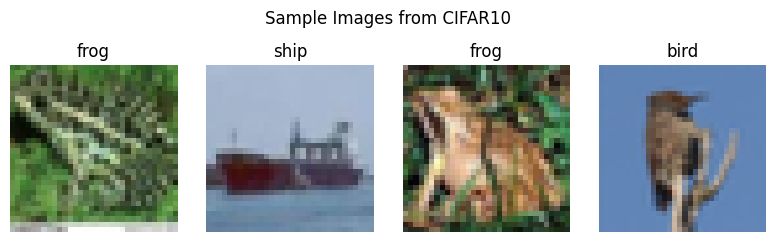


--- Splitting CIFAR10 Training Data ---
CIFAR10 sizes after split:
  Training Set:   45000
  Validation Set: 5000
  Test Set:       10000

--- Creating DataLoaders for CIFAR10 ---
DataLoaders created.

--- Initializing Model, Loss, Optimizer for CIFAR10 ---
Model, Loss, Optimizer Initialized.

--- Setting up TensorBoard for CIFAR10 ---
TensorBoard logs for CIFAR10 saved in: /Users/vinaygaddam/runs/CIFAR10_LeNet5

--- Training & Validating Model on CIFAR10 ---


Training CIFAR10:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [01/25], Train Loss: 1.6164, Train Acc: 41.19%, Val Loss: 1.4120, Val Acc: 49.02%, Time: 37.61s
Epoch [02/25], Train Loss: 1.3034, Train Acc: 52.90%, Val Loss: 1.2661, Val Acc: 54.32%, Time: 36.69s
Epoch [03/25], Train Loss: 1.1680, Train Acc: 58.25%, Val Loss: 1.1775, Val Acc: 57.56%, Time: 38.49s
Epoch [04/25], Train Loss: 1.0785, Train Acc: 61.98%, Val Loss: 1.0933, Val Acc: 61.14%, Time: 38.61s
Epoch [05/25], Train Loss: 1.0028, Train Acc: 64.53%, Val Loss: 1.0759, Val Acc: 61.68%, Time: 37.32s
Epoch [06/25], Train Loss: 0.9470, Train Acc: 66.76%, Val Loss: 1.0844, Val Acc: 62.88%, Time: 37.85s
Epoch [07/25], Train Loss: 0.9003, Train Acc: 68.57%, Val Loss: 1.0868, Val Acc: 61.46%, Time: 37.93s
Epoch [08/25], Train Loss: 0.8542, Train Acc: 69.79%, Val Loss: 1.0793, Val Acc: 64.14%, Time: 36.40s
Epoch [09/25], Train Loss: 0.8246, Train Acc: 70.97%, Val Loss: 1.0241, Val Acc: 64.84%, Time: 36.64s
Epoch [10/25], Train Loss: 0.7847, Train Acc: 72.37%, Val Loss: 1.0424, Val Acc: 6

Evaluating CIFAR10:   0%|          | 0/157 [00:00<?, ?it/s]

CIFAR10 Test Loss: 1.5698
CIFAR10 Test Accuracy: 61.59%

TensorBoard writer for CIFAR10 closed.
 COMPLETED EXPERIMENT FOR: CIFAR10 



In [14]:
# --- CIFAR-10 Setup ---
DATASET_NAME_C10 = 'CIFAR10'
print("\n" + "="*50)
print(f" STARTING EXPERIMENT FOR: {DATASET_NAME_C10} ")
print("="*50)

# Dataset specific config
dataset_class_c10 = datasets.CIFAR10
normalize_mean_c10 = (0.4914, 0.4822, 0.4465) # Standard mean/std for CIFAR10
normalize_std_c10 = (0.2023, 0.1994, 0.2010)
class_names_c10 = ('airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck')
in_channels_c10 = 3 # CIFAR10 has 3 color channels

# --- Step 1 & 3: Load Dataset and Define Preprocessing ---
print(f"\n--- Loading {DATASET_NAME_C10} and Defining Preprocessing ---")
transform_c10 = transforms.Compose([
    transforms.ToTensor(), # Step 5
    transforms.Normalize(normalize_mean_c10, normalize_std_c10)
])
try:
    full_train_dataset_raw_c10 = dataset_class_c10(root='./data', train=True, download=True)
    full_train_dataset_transformed_c10 = dataset_class_c10(root='./data', train=True, download=False, transform=transform_c10)
    test_dataset_c10 = dataset_class_c10(root='./data', train=False, download=True, transform=transform_c10)
except Exception as e:
    print(f"Error downloading or loading {DATASET_NAME_C10}: {e}")
    print("Please check your internet connection, SSL certificates, or disk space.")
    print("If issues persist, try downloading the dataset manually and placing it in the './data' directory.")
    # Optionally, add more robust error handling or exit

# --- Step 2: Explore and Visualize Data ---
if 'full_train_dataset_raw_c10' in locals(): # Check if dataset loaded successfully
    visualize_samples(full_train_dataset_raw_c10, class_names_c10, DATASET_NAME_C10)

# --- Step 4: Split Training Data ---
print(f"\n--- Splitting {DATASET_NAME_C10} Training Data ---")
num_train_total_c10 = len(full_train_dataset_transformed_c10)
num_val_c10 = int(VALIDATION_SPLIT * num_train_total_c10)
num_train_c10 = num_train_total_c10 - num_val_c10
generator_c10 = torch.Generator().manual_seed(SEED)
train_dataset_c10, val_dataset_c10 = random_split(full_train_dataset_transformed_c10, [num_train_c10, num_val_c10], generator=generator_c10)
print(f"{DATASET_NAME_C10} sizes after split:")
print(f"  Training Set:   {len(train_dataset_c10)}")
print(f"  Validation Set: {len(val_dataset_c10)}")
print(f"  Test Set:       {len(test_dataset_c10)}")

# --- Step 5: Create DataLoaders ---
print(f"\n--- Creating DataLoaders for {DATASET_NAME_C10} ---")
train_loader_c10 = DataLoader(dataset=train_dataset_c10, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader_c10 = DataLoader(dataset=val_dataset_c10, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader_c10 = DataLoader(dataset=test_dataset_c10, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print("DataLoaders created.")

# --- Initialize Model, Loss, Optimizer ---
print(f"\n--- Initializing Model, Loss, Optimizer for {DATASET_NAME_C10} ---")
model_c10 = LeNet5(num_classes=len(class_names_c10), in_channels=in_channels_c10).to(DEVICE)
criterion_c10 = nn.CrossEntropyLoss()
optimizer_c10 = optim.Adam(model_c10.parameters(), lr=LEARNING_RATE)
print("Model, Loss, Optimizer Initialized.")

# --- Step 6: Setup TensorBoard ---
print(f"\n--- Setting up TensorBoard for {DATASET_NAME_C10} ---")
log_dir_c10 = os.path.join(LOG_DIR_BASE, f"{DATASET_NAME_C10}_LeNet5")
writer_c10 = SummaryWriter(log_dir=log_dir_c10)
print(f"TensorBoard logs for {DATASET_NAME_C10} saved in: {os.path.abspath(log_dir_c10)}")

# --- Step 8 & 9: Train Model & Evaluate Train/Validation Accuracy ---
history_c10, best_metrics_c10 = train_model(
    model_c10, train_loader_c10, val_loader_c10, criterion_c10, optimizer_c10,
    NUM_EPOCHS, DEVICE, writer_c10, DATASET_NAME_C10
)

# --- Step 10: Evaluate on Test Set ---
results_c10 = evaluate_model(model_c10, test_loader_c10, criterion_c10, DEVICE, DATASET_NAME_C10)

# --- Close TensorBoard Writer ---
if writer_c10: writer_c10.close()
print(f"\nTensorBoard writer for {DATASET_NAME_C10} closed.")
print("="*50)
print(f" COMPLETED EXPERIMENT FOR: {DATASET_NAME_C10} ")
print("="*50 + "\n")


## 7. Results Analysis and Visualization

Plotting loss/accuracy curves and confusion matrices for both experiments.



--- Analyzing FashionMNIST Results ---


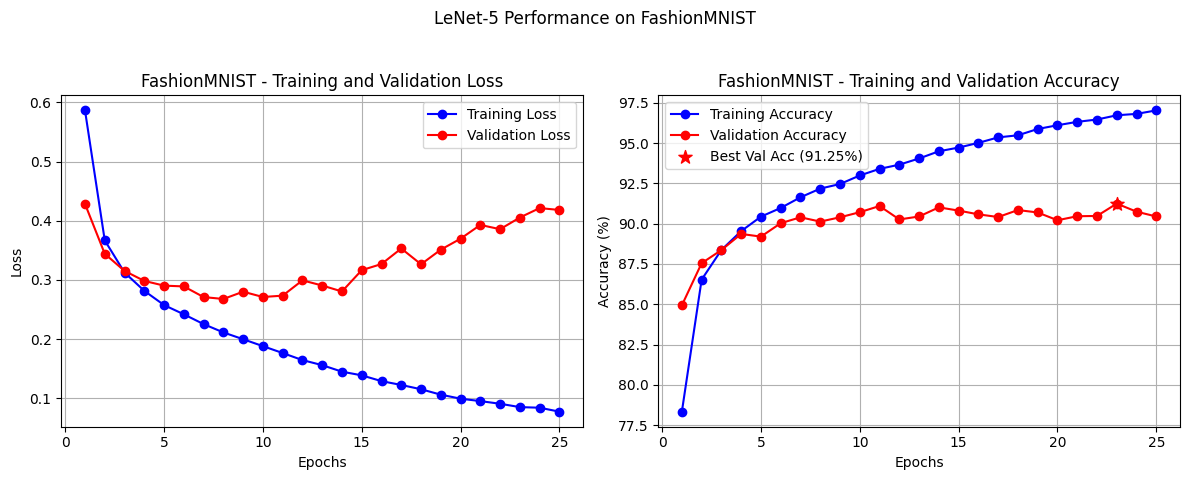

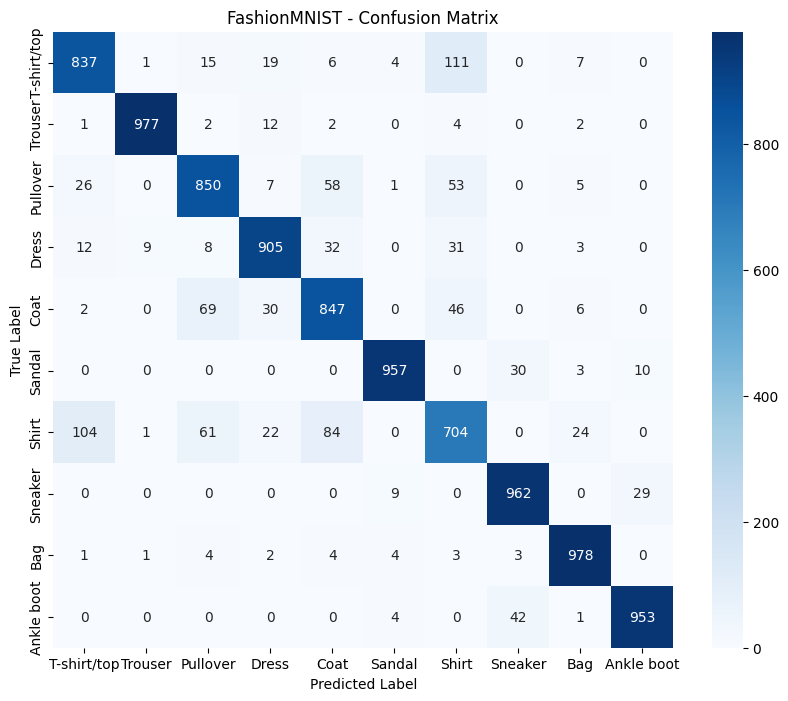


   RESULTS SUMMARY FOR: FashionMNIST
CNN Architecture:   LeNet-5
Epochs Trained:     25
Batch Size:         64
Learning Rate:      0.001
Optimizer:          Adam
Validation Split:   10%
------------------------------
Metrics at Epoch with Best Validation Accuracy:
  Epoch Number:        23
  Training Accuracy:   96.74%
  Validation Accuracy: 91.25%
  Training Loss:       0.0853
  Validation Loss:     0.4055
------------------------------
Final Test Set Metrics:
  Test Accuracy:       89.70%
  Test Loss:           0.4528
  Precision (weighted):0.8965
  Recall (weighted):   0.8970
  F1-Score (weighted): 0.8966

--- Analyzing CIFAR10 Results ---


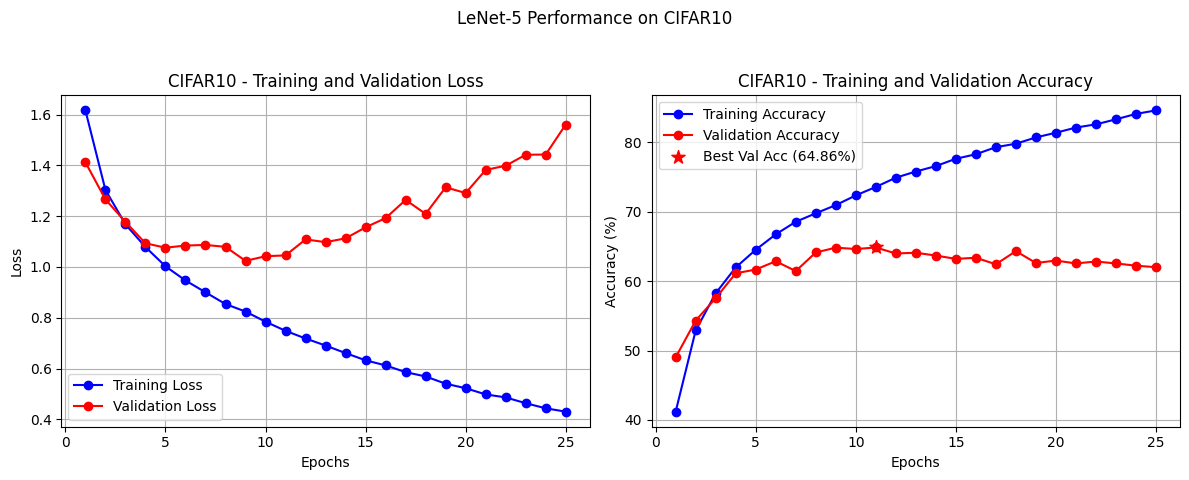

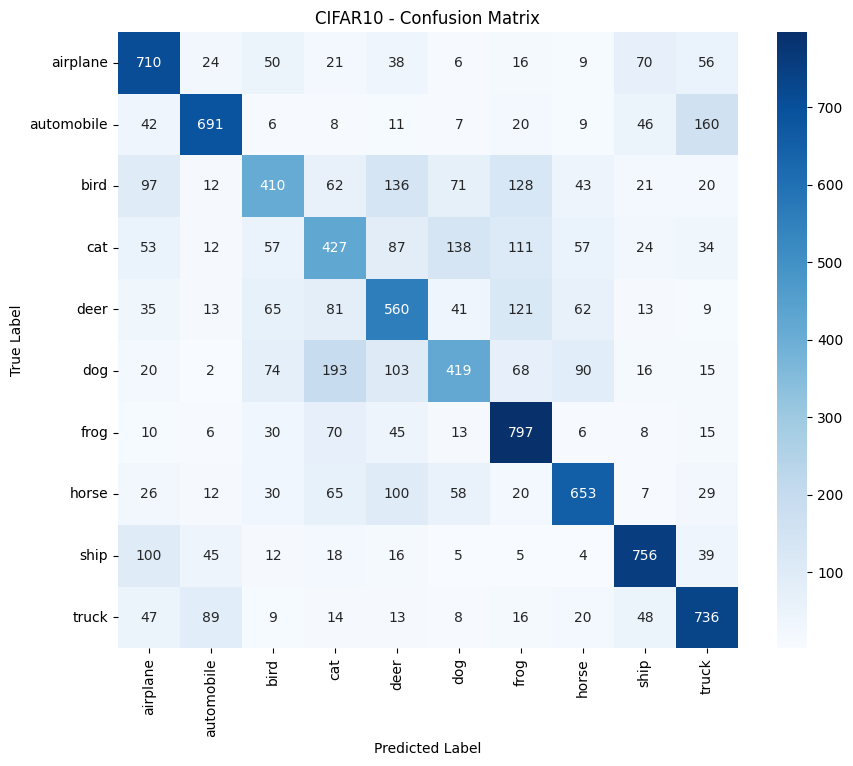


   RESULTS SUMMARY FOR: CIFAR10
CNN Architecture:   LeNet-5
Epochs Trained:     25
Batch Size:         64
Learning Rate:      0.001
Optimizer:          Adam
Validation Split:   10%
------------------------------
Metrics at Epoch with Best Validation Accuracy:
  Epoch Number:        11
  Training Accuracy:   73.59%
  Validation Accuracy: 64.86%
  Training Loss:       0.7488
  Validation Loss:     1.0457
------------------------------
Final Test Set Metrics:
  Test Accuracy:       61.59%
  Test Loss:           1.5698
  Precision (weighted):0.6142
  Recall (weighted):   0.6159
  F1-Score (weighted): 0.6111


In [15]:
# --- Function to Plot History ---
def plot_history(history, best_metrics, dataset_name):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title(f'{dataset_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title(f'{dataset_name} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    if best_metrics and 'epoch' in best_metrics and 'val_acc' in best_metrics: # Check if keys exist
         plt.scatter(best_metrics['epoch'], best_metrics['val_acc'], s=100, c='red', marker='*', label=f'Best Val Acc ({best_metrics["val_acc"]:.2f}%)')
    plt.legend()
    plt.grid(True)

    plt.suptitle(f"LeNet-5 Performance on {dataset_name}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Function to Plot Confusion Matrix ---
def plot_confusion_matrix(labels, predictions, class_names, dataset_name):
    if labels is None or predictions is None:
        print(f"Skipping confusion matrix for {dataset_name} due to missing labels or predictions.")
        return None
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{dataset_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return cm

# --- Function to Print Classification Metrics ---
def print_metrics_summary(results, dataset_name, best_metrics):
    if results['labels'] is None or results['predictions'] is None:
        print(f"Skipping metrics summary for {dataset_name} due to missing test results.")
        return

    print("\n" + "="*30)
    print(f"   RESULTS SUMMARY FOR: {dataset_name}")
    print("="*30)
    print(f"CNN Architecture:   LeNet-5")
    print(f"Epochs Trained:     {NUM_EPOCHS}")
    print(f"Batch Size:         {BATCH_SIZE}")
    print(f"Learning Rate:      {LEARNING_RATE}")
    print(f"Optimizer:          Adam")
    print(f"Validation Split:   {VALIDATION_SPLIT*100:.0f}%")
    print("-" * 30)
    print("Metrics at Epoch with Best Validation Accuracy:")
    if best_metrics and 'epoch' in best_metrics: # Check if best_metrics is populated
        print(f"  Epoch Number:        {best_metrics['epoch']}")
        print(f"  Training Accuracy:   {best_metrics.get('train_acc', 'N/A'):.2f}%")
        print(f"  Validation Accuracy: {best_metrics.get('val_acc', 'N/A'):.2f}%")
        print(f"  Training Loss:       {best_metrics.get('train_loss', float('nan')):.4f}")
        print(f"  Validation Loss:     {best_metrics.get('val_loss', float('nan')):.4f}")
    else:
        print("  Best validation metrics not available or training did not improve.")
    print("-" * 30)
    print("Final Test Set Metrics:")
    print(f"  Test Accuracy:       {results['test_acc']:.2f}%")
    print(f"  Test Loss:           {results['test_loss']:.4f}")
    # Calculate precision, recall, F1 if labels/predictions are available
    precision, recall, f1, _ = precision_recall_fscore_support(results['labels'], results['predictions'], average='weighted', zero_division=0)
    print(f"  Precision (weighted):{precision:.4f}")
    print(f"  Recall (weighted):   {recall:.4f}")
    print(f"  F1-Score (weighted): {f1:.4f}")
    print("="*30)

# --- Analyze FashionMNIST Results ---
print(f"\n--- Analyzing {DATASET_NAME_FM} Results ---")
if 'history_fm' in locals() and 'results_fm' in locals(): # Check if variables exist
    plot_history(history_fm, best_metrics_fm, DATASET_NAME_FM)
    cm_fm = plot_confusion_matrix(results_fm.get('labels'), results_fm.get('predictions'), class_names_fm, DATASET_NAME_FM)
    print_metrics_summary(results_fm, DATASET_NAME_FM, best_metrics_fm)
else:
    print(f"Could not analyze {DATASET_NAME_FM} results as training/evaluation data is missing.")


# --- Analyze CIFAR-10 Results ---
print(f"\n--- Analyzing {DATASET_NAME_C10} Results ---")
if 'history_c10' in locals() and 'results_c10' in locals(): # Check if variables exist
    plot_history(history_c10, best_metrics_c10, DATASET_NAME_C10)
    cm_c10 = plot_confusion_matrix(results_c10.get('labels'), results_c10.get('predictions'), class_names_c10, DATASET_NAME_C10)
    print_metrics_summary(results_c10, DATASET_NAME_C10, best_metrics_c10)
else:
    print(f"Could not analyze {DATASET_NAME_C10} results as training/evaluation data is missing.")



## 8. Conclusion

This notebook demonstrated the implementation and evaluation of the LeNet-5 architecture on both the FashionMNIST and CIFAR-10 datasets.

**Observations:**
* LeNet-5 achieved significantly higher performance on the FashionMNIST dataset compared to CIFAR-10. The final test accuracy for FashionMNIST was 89.70%, with a best validation accuracy of 91.25% (achieved at epoch 23). In contrast, for CIFAR-10, the final test accuracy was 61.59%, with a best validation accuracy of 64.86% (achieved at epoch 11). This performance difference is expected, given that FashionMNIST consists of simpler, grayscale images, while CIFAR-10 presents a more challenging task with complex, color images across diverse categories.
* For FashionMNIST, the training accuracy at the epoch with the best validation accuracy was 96.74%, while the validation accuracy was 91.25%. This indicates a moderate degree of overfitting, as the model performed better on the data it was trained on compared to unseen validation data. The training and validation curves likely showed good convergence, but with a noticeable gap emerging in later epochs.
* For CIFAR-10, the overfitting appeared more pronounced. At the epoch with the best validation accuracy, the training accuracy was 73.59% against a validation accuracy of 64.86%. This larger gap suggests that the standard LeNet-5 architecture, while capable of learning, might lack the capacity or regularization needed to generalize as effectively to the complexity of the CIFAR-10 dataset. The training and validation accuracy curves likely diverged more significantly and earlier compared to FashionMNIST.
* The confusion matrices (which would be generated by the `plot_confusion_matrix` function) would further highlight specific class-wise performance. For FashionMNIST, common confusions might occur between visually similar items like 'T-shirt/top', 'Shirt', and 'Pullover'. For CIFAR-10, distinguishing between classes such as 'cat' and 'dog', or various types of vehicles, is a known challenge for simpler architectures and would likely be reflected in the matrix.

**Further Steps:**
* **Hyperparameter Tuning:** Experiment with different learning rates, batch sizes, optimizers (e.g., SGD with momentum), and number of epochs.
* **Data Augmentation:** Apply techniques like random rotations, flips, and color jitter (especially for CIFAR-10) to increase the diversity of the training set and improve generalization.
* **Regularization:** Explore adding dropout layers within the fully connected part of LeNet-5 or using weight decay (L2 regularization) to combat overfitting, particularly for CIFAR-10.
* **Architectural Modifications:**
    * Increase the number of filters or layers in LeNet-5.
    * Implement and compare with more modern CNN architectures (e.g., a simple VGG-like model, or a small ResNet).
* **Learning Rate Scheduling:** Implement a learning rate scheduler that reduces the learning rate during training, which can help in fine-tuning the model.
* **More Datasets:** Test the implemented LeNet-5 on other datasets mentioned in the project (e.g., MNIST, SVHN) for a broader comparison.
